In [1]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import pandas as pd

from scipy.spatial.distance import euclidean
from numpy import array, zeros, argmin, inf, equal, ndim
from scipy.spatial.distance import cdist

In [2]:
d1 = glob.glob('Datasets/digit_data/isolated/36/1/*')
d2 = glob.glob('Datasets/digit_data/isolated/36/2/*')
d3 = glob.glob('Datasets/digit_data/isolated/36/3/*')

In [3]:
def load_mfcc(list_paths):
    X = []
    for i in list_paths:
        X.append(np.array(pd.read_csv(i, sep = " ", skiprows = [0], header = None))[:,1:])

    return np.array(X)

def combine(X):
    temp_X = []

    for i in X:
        for j in i:
            temp_X.append(j)

    return np.array(temp_X)

In [4]:
# Load and structure data
X1 = load_mfcc(d1)
X2 = load_mfcc(d2)
X3 = load_mfcc(d3)

# Train Test data partition
X1_train,X1_test = train_test_split(X1, test_size=0.3, random_state=42)
X2_train,X2_test = train_test_split(X2, test_size=0.3, random_state=42)
X3_train,X3_test = train_test_split(X3, test_size=0.3, random_state=42)

In [5]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [6]:
def dtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return (D1[-1, -1] / sum(D1.shape), C, D1, path)

In [7]:
def fastdtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences in a faster way.
    Instead of iterating through each element and calculating each distance,
    this uses the cdist function from scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)

    :param array x: N1*M array
    :param array y: N2*M array
    :param string or func dist: distance parameter for cdist. When string is given, cdist uses optimized functions for the distance metrics.
    If a string is passed, the distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    if ndim(x)==1:
        x = x.reshape(-1,1)
    if ndim(y)==1:
        y = y.reshape(-1,1)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]
    D0[1:,1:] = cdist(x,y,dist)
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return (D1[-1, -1] / sum(D1.shape), C, D1, path)

In [68]:
from sklearn.metrics.pairwise import euclidean_distances
from nltk.metrics.distance import edit_distance
from sklearn.metrics.pairwise import manhattan_distances

#dist_fun = euclidean_distances

In [72]:
template = X1_train[0]
test = X1_train[0]
dist_fun = lambda template, test: np.linalg.norm(template - test, ord=1)

In [73]:
dist, cost, acc, path = fastdtw(template, test, dist_fun)

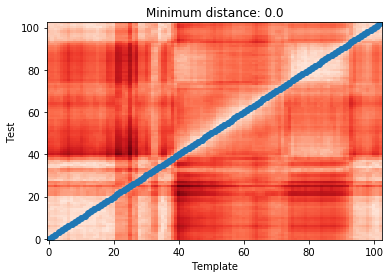

In [74]:
# vizualize

x = template
y = test

from matplotlib import pyplot as plt
plt.imshow(cost.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], '-o') # relation
#plt.xticks(range(len(x)))
#plt.yticks(range(len(y)))
plt.xlabel('Template')
plt.ylabel('Test')
plt.axis('tight')
plt.title('Minimum distance: {}'.format(dist))
plt.show()

In [116]:
first_limit = X1_train.shape[0]-1
second_limit = first_limit + X2_train.shape[0] 
third_limit = second_limit + X3_train.shape[0]

In [118]:
test_data = np.hstack((X1_test, X2_test, X3_test))

In [188]:
from datetime import datetime
startTime = datetime.now()

no_of_classes = 3

predict = np.array([-1] * test_data.shape[0])
min_dist = np.array([-1] * test_data.shape[0])
predicted_scores = np.zeros((test_data.shape[0], no_of_classes))


for j in range(test_data.shape[0]):
    y = test_data[j]
    
    distance = []
    tmp1 = [] # stores class wise minimum
    tmp2 = [] # stores class wise minimum
    tmp3 = [] # stores class wise minimum
    for i in range(X1_train.shape[0]):
        x = X1_train[i]
        dist_fun = lambda x, y: np.linalg.norm(x - y, ord=1)
        dist, cost, acc, path = fastdtw(x, y, dist_fun)
        distance.append(dist)
        tmp1.append(dist)
        
    predicted_scores[j][0] = min(tmp1)

    for i in range(X2_train.shape[0]):
        x = X2_train[i]
        dist_fun = lambda x, y: np.linalg.norm(x - y, ord=1)
        dist, cost, acc, path = fastdtw(x, y, dist_fun)
        distance.append(dist)
        tmp2.append(dist)
    
    predicted_scores[j][1] = min(tmp2)
    
    for i in range(X3_train.shape[0]):
        x = X3_train[i]
        dist_fun = lambda x, y: np.linalg.norm(x - y, ord=1)
        dist, cost, acc, path = fastdtw(x, y, dist_fun)
        distance.append(dist)
        tmp3.append(dist)
        
    predicted_scores[j][2] = min(tmp3)
    
    index = argmin(distance)
    min_dist[j] = min(distance) # minimum amongst all classes

    if index <= first_limit:
        predict[j] = 1
    elif index > first_limit and index < second_limit:
        predict[j] = 2
    else:
        predict[j] = 3
        
print(datetime.now() - startTime)
print(predict[36])

0:11:53.410720
2


In [184]:
actual_test_labels = np.hstack((np.array([1]*X1_test.shape[0]), np.array([2]*X2_test.shape[0]), np.array([3]*X3_test.shape[0])))

In [187]:
predict[36] = 3

In [136]:
score = 0
descore = 0
misclassified = []
for i in range(test_data.shape[0]):
    if actual_test_labels[i] == predict[i]:
        score += 1
    else:
        descore += 1
        misclassified.append(i)
        
rec_rate = score / test_data.shape[0]
print('Recognition rate {}%'.format(100. * rec_rate))

Recognition rate 100.0%


In [140]:
# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [142]:
actualLabels = actual_test_labels
predictedLabels = predict

Confusion matrix, without normalization
[[18  0  0]
 [ 0 18  0]
 [ 0  0 18]]
Normalized confusion matrix
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


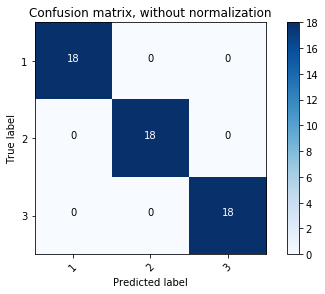

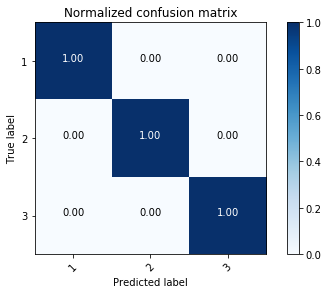

In [143]:
from sklearn.metrics import confusion_matrix
import itertools

# Compute confusion matrix
cnf_matrix = confusion_matrix(actualLabels, predictedLabels)
np.set_printoptions(precision=2)
class_names = ['1', '2', '3'];

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [190]:
# ROC Curve

def roc(no_of_test_points, no_of_classes, actualValues, score ):

    #no_of_test_points = test_data.shape[0]
    #no_of_classes = 3
    
    TPR = []
    FPR = []
    FNR = []
    t = []

    for threshold in np.arange(0, 1, 0.0001):
        t.append(threshold)
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        for i in range(0, no_of_test_points):
            for j in range(0, no_of_classes):
                if actualValues[i] == j+1:
                    if score[i][j] >= threshold:  
                        TP = TP+1
                    elif score[i][j] < threshold:
                        FN = FN+1
                else:
                    if score[i][j] >= threshold:
                        FP = FP+1
                    elif score[i][j] < threshold:
                        TN = TN+1
        tpr = TP / (TP + FN)  
        fpr = FP / (FP + TN)
        fnr = FN / (TP + FN)
        TPR.append(tpr)
        FPR.append(fpr)
        FNR.append(fnr)
        #roc_auc.append(auc(fpr, tpr))
    rocPlot(FPR, TPR)
    return (FPR, TPR, FNR)


    
def rocPlot(FPR, TPR):
    plt.figure()
    lw = 2
    
    #FPR = [i-0.8 for i in FPR]
    #TPR = [i-0.8 for i in TPR]
    
    plt.plot(TPR, FPR, color='darkorange', lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [191]:
def min_max_normalize(X):
    return (X-min(X))/(max(X)-min(X))

def mean_var_normalize(X):
    return (X-np.mean(X))/np.var(X)

In [192]:
predicted_scores_copy = predicted_scores
predicted_scores_copy = np.column_stack((min_max_normalize(predicted_scores_copy[:, 0]), min_max_normalize(predicted_scores_copy[:, 1]), min_max_normalize(predicted_scores_copy[:, 2])))

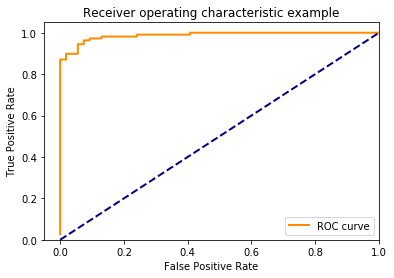

In [194]:
# roc(no_of_test_points, no_of_classes, actualValues, score )
# predicted_scores.shape = (no_of_test_points, no_of_classes)

(fpr, tpr, fnr) = roc(test_data.shape[0], 3, actualLabels, predicted_scores_copy )

In [ ]:
def plot_DET_with_EER(far, frr, far_optimum, frr_optimum):
    """ Plots a DET curve with the most suitable operating point based on threshold values"""

    # Plot the DET curve based on the FAR and FRR values
    plt.plot(far, frr, linestyle="--", linewidth=4, label="DET Curve")

    # Plot the optimum point on the DET Curve
    plt.plot(far_optimum,frr_optimum, "ro", label="Suitable Operating Point")

    # Draw the default DET Curve from 1-1
    plt.plot([1.0,0.0], [0.0,1.0],"k--")

    # Draws the key/legend
    plot_legends()

    # Displays plots
    show_plot()


In [215]:
from matplotlib import pyplot as plt
import matplotlib
def DETCurve(fps,fns):
    """
    Given false positive and false negative rates, produce a DET Curve.
    The false positive rate is assumed to be increasing while the false
    negative rate is assumed to be decreasing.
    """
    axis_min = min(fps[0],fns[-1])
    fig,ax = plt.subplots()
    plt.plot(fps,fns)
    plt.yscale('log')
    plt.xscale('log')
    ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50]
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    plt.axis([0.001,50,0.001,50])

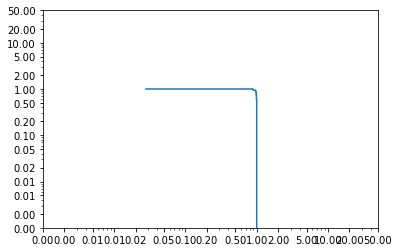

In [216]:
DETCurve(fpr, fnr)